# Assignment 1: Time-series data

**This assignment consists of five parts:**

1. Create synthetic data to test the algorithm you design.
2. Write two functions:
    - autocorrelation.
    - period extraction function.
3. Use a periodogram function.
4. Compare the sensitivity of the algorithms to typical imperfections occur in real data (noise, missing data, random and non-periodic patterns).
5. Test the algorithms on geolife data.
 


Part 1-3 will make up **60% of your grade**, part 4 and 5 constitute **40% of your grade**.

**WARNING: Make sure to read through the entire assignment before starting to code. The tasks build on each other!**

Good luck with the assignment! Deadline is **October 5th, at 23:55** hrs. Please push your code to the GitHub classroom before the deadline. **Make sure to read the *"Submission procedure"* section in the *"README.md"* file to ensure reproducibility.**


## 0th part: Prerequisites
Please add any packages you use to the code cell below.

In [34]:
#pip install openrouteservice
#pip install folium

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import openrouteservice as opn      
from openrouteservice.directions import directions
from openrouteservice import convert
import numpy as np
import pandas as pd
import math
from scipy.signal import find_peaks
import warnings
import random
warnings.filterwarnings("ignore")


api_key='5b3ce3597851110001cf6248d07b7aba40dc4bee805213a6b388ca0d'
client = opn.Client(key=api_key)
# etc.



## 1st part: Create Synthetic Data

Imagine that you have a GPS device that takes a measurement every 10 minutes. Create a synthetic data trajectory with two periodicities for 365 days. The trajectory data should include two types of periodicities (e.g., one daily and one weekly).

In [36]:
## calculate the 1-dimension distance ：base on Lat^2+Long^2##
def positions (decodedCircuit) :
    matrix_latlong = np.matrix (decodedCircuit)
    positions = []
    for i in range(len(matrix_latlong)):
        lat = math.pow(matrix_latlong[i,0],2)
        long = math.pow(matrix_latlong[i,1],2)
        position = lat +long
        positions.append(position)
    return positions


def travel(center_cord, direction_cord, decodedCircuit_go, decodedCircuit_back, time, start_time) : 
    ''' 
    Parameters:
        time == how long between center_cord and one direction_cord
        start_time == when I start leave my home, which is used for the Part 4(add noisy data)
        travel == positions in every day
        There are 5 parts in one travel : morning_stay_center,
                                          from home to direction, 
                                          stay at direction, 
                                          from direction to center
                                          evening_stay_center
    '''

    # 1-morning stay center
    # due to leaving at start_time am 
    position_stay_center = math.pow(np.array(center_cord)[0], 2) + math.pow(np.array(center_cord)[1], 2)
    morning_stay_center = np.repeat(position_stay_center, start_time * 6)
    
    # 2-from center to the direction
    indices_go = np.round(np.linspace(1,len(decodedCircuit_go) , time // 10)) 
    go = np.asarray(positions(decodedCircuit_go))[indices_go.astype(int)- 1]
        
    # 3-stay at the direction
    position_stay_direction = math.pow(np.array(direction_cord)[0],2) + math.pow(np.array(direction_cord)[1], 2)
    stay_direction = np.repeat(position_stay_direction, (((17-start_time) * 60 - time) // 10))
    
    # 4-from direction to the center
    indices_back = np.round(np.linspace(1,len(decodedCircuit_back) , time // 10)) 
    back = np.asarray(positions(decodedCircuit_back))[indices_back.astype(int)- 1]

    # 5-in evening stay at center
    evening_stay_center = np.repeat(position_stay_center, ((7 * 60-time) // 10))
    
    ####  sum(5 parts)
    travel1 = np.append(morning_stay_center, go)
    travel2 = np.append(back, evening_stay_center)
    travel3 = np.append(travel1, stay_direction)
    
    travels = np.append(travel3, travel2)
    
    return  travels

# simulate data infrom of two timeseries lat and long of length (144 * 365):
def simulate(home_coord, supermarket_coord, snellius_coord): 
    
    leg_one = (home_coord, snellius_coord)
    leg_two = (snellius_coord, home_coord)
    leg_three = (home_coord, supermarket_coord)
    leg_four = (supermarket_coord, home_coord)

    # decode_polyline needs the geometry only
    geom_one = client.directions(leg_one)['routes'][0]['geometry']
    leg_one_decoded = convert.decode_polyline(geom_one)['coordinates']

    geom_two = client.directions(leg_two)['routes'][0]['geometry']
    leg_two_decoded = convert.decode_polyline(geom_two)['coordinates']

    geom_three = client.directions(leg_three)['routes'][0]['geometry']
    leg_three_decoded = convert.decode_polyline(geom_three)['coordinates']

    geom_four = client.directions(leg_four)['routes'][0]['geometry']
    leg_four_decoded = convert.decode_polyline(geom_four)['coordinates']
    
    # seperate weekday and weekend 
    travel_weekdays = travel (home_coord, snellius_coord, leg_one_decoded, leg_two_decoded, 120, 8) # every morening start at 8.AM
    travel_weekends = travel (home_coord, supermarket_coord, leg_three_decoded, leg_four_decoded, 200, 8)
    travel_week = np.c_[travel_weekdays, travel_weekdays, travel_weekdays, travel_weekdays, travel_weekdays, travel_weekends, travel_weekends]
    
    travel_365 = np.zeros(shape=(144, 364))
    for i in range(52) :
        travel_365[:,i*7:i*7+7] = travel_week
    
    simulatedData_2d = np.c_[travel_365, travel_weekdays]

    return simulatedData_2d

In [37]:
# Display the Synsetic data
home_coord            =    [4.448155,52.153409]                    
supermarket_coord     =    [4.493196 ,52.154944]                
snellius_coord        =    [4.457111 ,52.169709]   

simulate_data_2d = simulate(home_coord, supermarket_coord, snellius_coord)
simulate_data_T = simulate_data_2d.T      # simulate_data_T: the rows represent 365 days, the coluim represent 144 record perday
simulate_data = simulate_data_T.flatten() # transfer 2d array to 1d array
# print(simulate_data)

# Verify data
print(type(simulate_data))
print(simulate_data_2d.shape,': shape of 2-dimensional synthetic data.')
print(simulate_data.shape, ': shape of 1-dimensional (total) synthetic data.')
print(simulate_data[0:5], ': first 5 data of first day')
print(simulate_data.shape[0] // 365, 'records per day')
print(simulate_data.shape[0] // (365 * 24), 'records per hour')

<class 'numpy.ndarray'>
(144, 365) : shape of 2-dimensional synthetic data.
(52560,) : shape of 1-dimensional (total) synthetic data.
[2739.76415323 2739.76415323 2739.76415323 2739.76415323 2739.76415323] : first 5 data of first day
144 records per day
6 records per hour


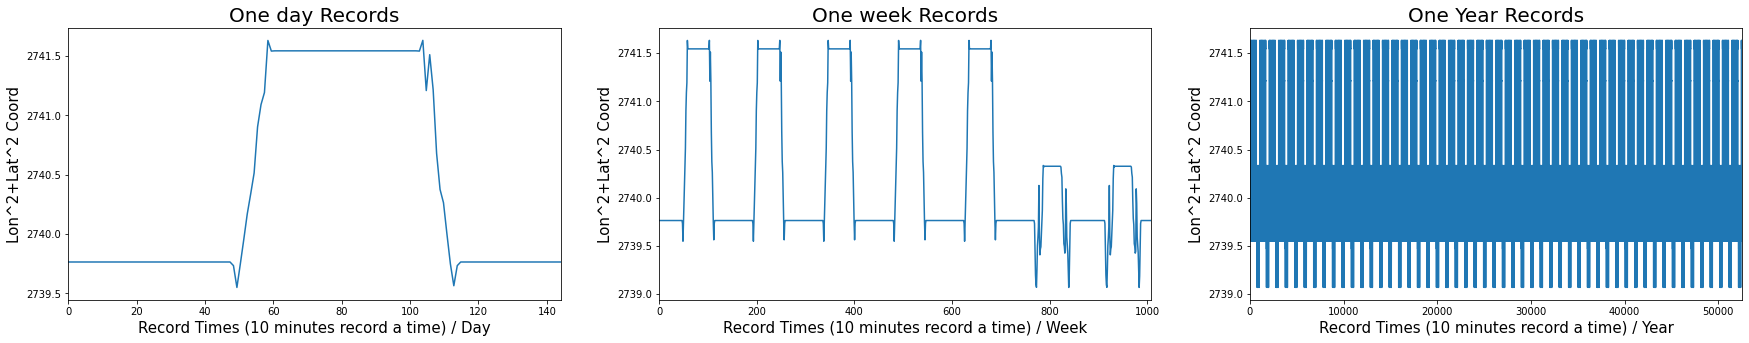

In [38]:
'''Visuilize my generated data'''
fig, ax = plt.subplots(1, 3, figsize=(30,5))

# one weekday signal record
x1 = np.linspace(0,len(simulate_data_T[0]),len(simulate_data_T[0]))
y1 = simulate_data_T[0,:]  # 144
ax[0].plot(x1, y1)  
ax[0].set_xlim(0, 144)
ax[0].set_xlabel('Record Times (10 minutes record a time) / Day', fontsize=15) 
ax[0].set_ylabel('Lon^2+Lat^2 Coord',fontsize=15)
ax[0].set_title ('One day Records',fontsize=20)

# one week signal record
x2 = np.linspace(0,len(simulate_data_T[0]) * 7 ,len(simulate_data_T[0]) * 7)
y2 = simulate_data[:len(simulate_data_T[0]) * 7]   # 144 * 7 =1008
ax[1].plot(x2, y2)  
ax[1].set_xlim(0, 1008)
ax[1].set_xlabel('Record Times (10 minutes record a time) / Week', fontsize=15) 
ax[1].set_ylabel('Lon^2+Lat^2 Coord', fontsize=15)
ax[1].set_title ('One week Records', fontsize=20)

# one year signal record
x3 = np.linspace(0,len(simulate_data),len(simulate_data))
y3 = simulate_data[:len(simulate_data_T[0]) * 365]   # 144 * 365 = 52560
ax[2].plot(x3, y3)  
ax[2].set_xlim(0, 52560)
ax[2].set_xlabel('Record Times (10 minutes record a time) / Year', fontsize=15) 
ax[2].set_ylabel('Lon^2+Lat^2 Coord',fontsize=15)
ax[2].set_title ('One Year Records', fontsize=20)

plt.show()

## 2nd part: Write two functions

Normal temporal autocorrelation:

$$ACF_\tau = \frac{1}{T - \tau} \sum_{t=1}^{T-\tau} (x_t - \bar{x})(x_{t+\tau} - \bar{x})$$

Circular temporal autocorrelation:

$$ACF_\tau = \frac{1}{T} \sum_{t=1}^{T} (x_t - \bar{x})(x_{MOD(t+\tau, T)} - \bar{x})$$

Breakdown of the symbols:

- $\tau$ the lag that we're computing the autocorrelation for
- $T$ the total length of our time series
- $t$ a specific moment in time
- $x$ a vector of two elements (longitude, latitude) indicating a point in space
- $x_t$ the value of $x$ at time $t$, so a point in space and time
- $\bar{x}$ the mean value of $x$ in all our observations

The multiplication $(x_t - \bar{x})(x_{t+\tau} - \bar{x})$ is the dot product (or "inner product" or "scalar product") of these vectors.

### Q 2.1

In [39]:
# write your own ACF
def get_auto_corr(timeSeries, k):
    '''
        Input：timeSeries，delay k
        Output：k-order autocorrelation value of timeSeries
        l：length of timeSeries
    '''
    l = len(timeSeries)
    timeSeries1 = timeSeries[0:l-k]
    timeSeries2 = timeSeries[k:]
    timeSeries_mean = timeSeries.mean()
    timeSeries_var = np.array([i**2 for i in timeSeries-timeSeries_mean]).sum()
    auto_corr = 0
    for i in range(l-k):
        temp = (timeSeries1[i]-timeSeries_mean)*(timeSeries2[i]-timeSeries_mean)/timeSeries_var
        auto_corr = auto_corr + temp  
    return auto_corr

# write my own Cicular_ACF
def autocorrelation(x, lags): 
	n = len(x)
	x = np.array(x)
	result = [np.correlate(x[i:]-x[i:].mean(),x[:n-i]-x[:n-i].mean())[0]\
		/(x[i:].std()*x[:n-i].std()*(n-i)) \
		for i in range(1,lags+1)]
	return result

In [40]:
# The computing process estimated cost 25 seconds
# get_auto_corr(simulate_data, 38)
autocorr = autocorrelation(simulate_data, len(simulate_data)-1)
print( len(autocorr)  )
print( type(autocorr) )

52559
<class 'list'>


Then, let's see all delay possibilities for simulate_data by using autocoorelation function:

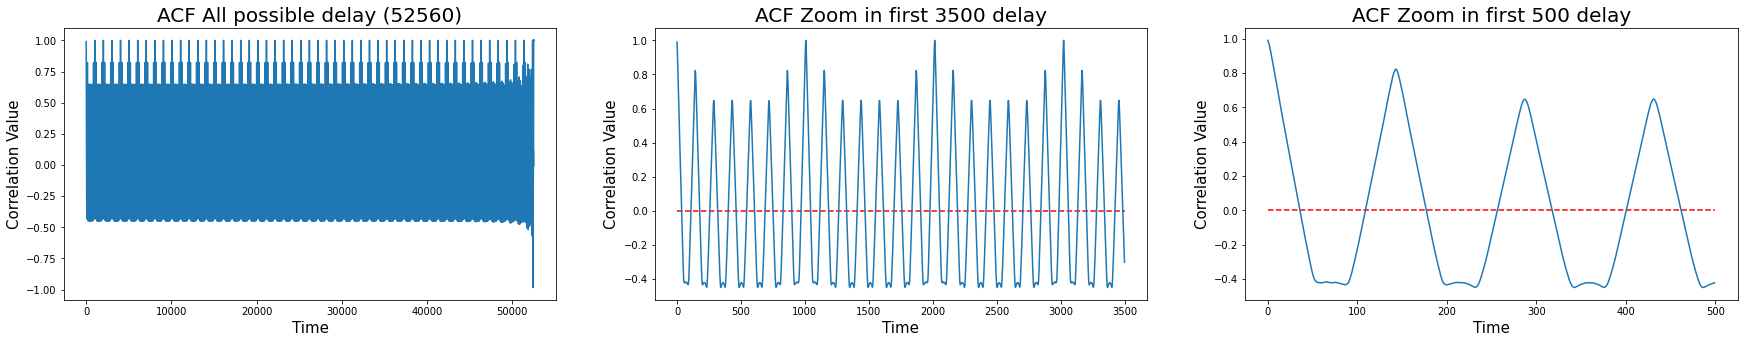

In [41]:
# Show all possible delay and explore more

x = np.linspace(0,len(autocorr),len(autocorr))
y = autocorr

fig, ax = plt.subplots(1, 3, figsize=(30,5))

ax[0].plot(x, y)  # first exploration
ax[0].set_title('ACF All possible delay (52560)', fontsize=20)
ax[0].set_xlabel('Time', fontsize=15)
ax[0].set_ylabel('Correlation Value', fontsize=15)

ax[1].plot(x[:3500], y[:3500])  # narrowing it down a bit
ax[1].set_title('ACF Zoom in first 3500 delay', fontsize=20)
ax[1].set_xlabel('Time', fontsize=15)
ax[1].set_ylabel('Correlation Value', fontsize=15)
ax[1].hlines(0, 0, 3500,color="red", linestyle='--')

ax[2].plot(x[:500], y[:500])  # zooming in even further
ax[2].set_title('ACF Zoom in first 500 delay', fontsize=20)
ax[2].set_xlabel('Time', fontsize=15)
ax[2].set_ylabel('Correlation Value', fontsize=15)
ax[2].hlines(0, 0, 500,color="red", linestyle='--')#横线
plt.show()


### Q 2.2

In [42]:
# write your evaluation function

def autocorr_periodicity(simulated_data):
    autocorr = autocorrelation(simulate_data, len(simulate_data)-1)
    acf = np.array(autocorr)
    acf_index, _ = find_peaks(acf, height= 0.85)
    index_differ = np.diff(acf_index)
    autocorr_periods = np.mean(index_differ)
    # print(mean_differ)

    return autocorr_periods, acf_index

In [43]:
# Process evaluation (this process may estimated 20 seconds)
autocorr_periods,  acf_index = autocorr_periodicity(simulate_data)
print('The dominant period is :', autocorr_periods)

The dominant period is : 1008.0


To validate the autocorr_periodicity, we plot the ACF digram below to see if 1008 timestamp would appear a peak? Then we can saw the figure shows that the dominant period exactly sit at the maxmium peak (red stars) every 1008 timestamp ie. One Week, therefore it meet our expectation:

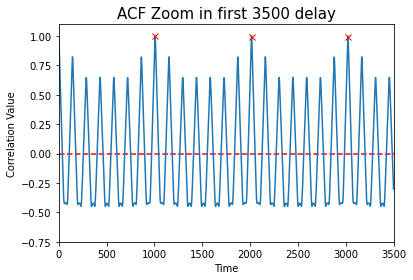

In [44]:
x = np.linspace(0,len(autocorr),len(autocorr))
y = np.array(autocorr)
plt.plot(x[:3500], y[:3500])  # draw wave
plt.plot(acf_index[0], y[acf_index[0]] , "x", color="red") # mark the peak
plt.plot(1008*2, y[1008*2] , "x", color="red") 
plt.plot(1008*3, y[1008*3], "x", color="red") 
plt.xlim(0, 3500)
plt.ylim(-0.75, 1.1)
plt.xticks()
plt.yticks()
plt.title('ACF Zoom in first 3500 delay', fontsize=15)
plt.xlabel('Time', fontsize=10) 
plt.ylabel('Correlation Value', fontsize=10) 
plt.hlines(0, 0, 3500,color="red", linestyle='--')
plt.show()

## 3rd part: Periodograms

The evaluation function from the 2nd part DO NOT works on the results of the periodogram.

In 2nd part, it shows the best period is one week(1008), this is because we assume the best period is related the ACF highest peak.

However, in this part, we use the "scipy.signal.periodogram" which transform "ACF value" to "power spectral density (PSD)" by Fourier Transform.

It means compared the method in part2, this way could find more details.

So, in terms of scipy function, compared to the One week period, One day period seems more comprehensive.

### Q 3.1

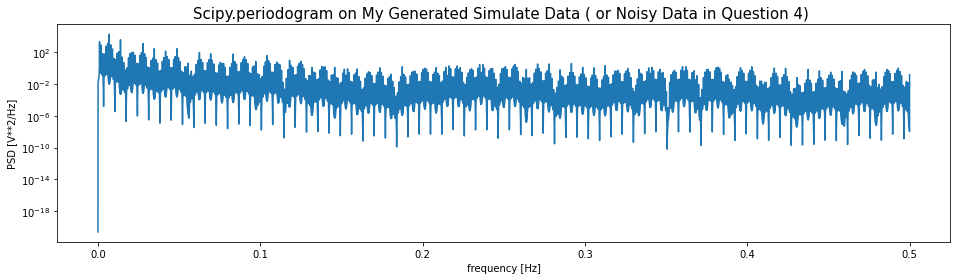

The period of Scipy.periodogram is: 144.0


In [60]:
# work with periodogram, find a function available in one of the python packages
from scipy import signal
def scipy_periodogram(data):
    f, Pxx_den = signal.periodogram(data)
    a  = signal.periodogram(data)

    plt.figure(figsize=(16,4))
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title('Scipy.periodogram on My Generated Simulate Data ( or Noisy Data in Question 4) ', fontsize=15)
    plt.show()

    peaks_big_small = sorted(a[1], reverse = True)
    i = list(a[1]).index(peaks_big_small[0])
    xx=a[0]
    periodogramPeriods = 1/xx[i]
    return periodogramPeriods

print('The period of Scipy.periodogram is:', scipy_periodogram(simulate_data)) 

### Q 3.2 

I also try to write my own periodogram function below for interesting, but the Q 3.3 new evaluation function is for Q 3.1 scipy.signal.periodogram not for this (my own) writen periodogram function .

My own writen periodogram detected domain period is (almost 2 days): 276.6315789473684


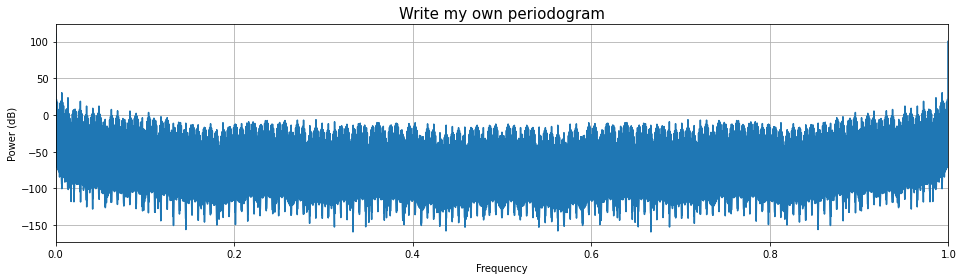

In [46]:
# write your own periodogram function if needed
'''it's just a try to use spectrum library to re-identify a periodogram '''
from spectrum import *
def my_periodogram(data):
    p = Periodogram(data, 1)
    a=sorted(p.frequencies(), reverse = False)
    period = 1/a[190]   
    return period, p

my_peirod, p = my_periodogram(simulate_data)
plt.figure(figsize=(16,4))
plt.title('Write my own periodogram', fontsize=15)
p.plot(sides='twosided')
print('My own writen periodogram detected domain period is (almost 2 days):', my_peirod)

### Q 3.3

Below new desigend evaluate function is to evaluate the Q3.1 Scipy.signal.periodogram result

In [47]:
# evaluate results of periodogram, write your evaluation function
def autocorr_periodicity_new(simulate_data):
    autocorr = autocorrelation(simulate_data, len(simulate_data)-1)
    acf = np.array(autocorr)
    acf_index, _ = find_peaks(acf, height= 0)
    index_differ = np.diff(acf_index)
    autocorr_periods = np.mean(index_differ)
    # print(mean_differ)

    return autocorr_periods, acf_index

autocorr_periods,  acf_index = autocorr_periodicity_new(simulate_data)
print('The dominant period is :', autocorr_periods)

The dominant period is : 143.5068493150685


It might be difficult to find all the correct dominant peaks so we will be lenient in grading if we can see that the code is correct.

## 4th part: Performance

Noise in the data can have two different causes:

- Missing measurements at different proportions (randomly or in bursts).
- Irregular behavior by skipping or adding a trajectory. For example, going to school on a saturday or skipping groceries for a week. You can also define a number of new places and paths and add them to the trajectory randomly (e.g. going to the cinema every month with some probability)

### Q 4.1

In [48]:
# add missing noise that every 1 hour the record will loos recording a data (10 * 6 = 60 min =1h)
def add_noise_one(data, rate): 
    data = data.copy()
    noise_number = int(len(data) * rate)
    noise_time = (np.round(np.random.uniform(0,1, noise_number)*len(data))).astype(int)
    for i in noise_time:
        data[i-6] = 0
    noisy_data = data
    
    return noisy_data

In [49]:
# add irregular behavior by skipping or adding a trajectory
# some days do not go to school or faculty, but go to cinemaCord = [4.432768,52.156794]
def add_noise_two(data, rate):
    homeCord   =    [4.448155,52.153409]                                    
    cinemaCord = [4.432768,52.156794]
    snelliusCord =  [ 4.457111 ,52.169709] 
    start_time = 8
    
    coords_home_cinema = (homeCord,snelliusCord)
    coords_cinema_home = (snelliusCord,homeCord)

    geometry_home_cinema = client.directions(coords_home_cinema)['routes'][0]['geometry']
    geometry_cinema_home = client.directions(coords_cinema_home)['routes'][0]['geometry']

    decodedCircuit_home_cinema = convert.decode_polyline(geometry_home_cinema)['coordinates']
    decodedCircuit_cinema_home = convert.decode_polyline(geometry_cinema_home)['coordinates']

    travels_noise = travel(homeCord,cinemaCord,decodedCircuit_home_cinema,decodedCircuit_cinema_home,120,start_time)
                           
    noise_index = [random.randint(1,52) for _ in range(int(52*rate)) ]
                           
    for i in noise_index :
        data[:,i] = travels_noise                   
    
    noisydata = data
    
    return noisydata

### Q 4.2

-------------------------------For Noisy data 1-----------------------------------------
The dominant period of original ACF in Q.2 is : 1008.0
My own periodogram period in Q.3.2 is : 276.6315789473684
The new evaluation function finded period of  ACF in Q.3.3 is:  3.4528252299605784


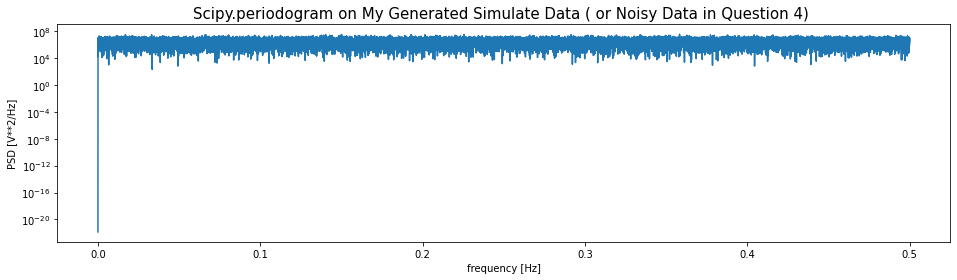

The Scipy.periodogram given period in Q.3.1 is : 2.790845855678861
-------------------------------For Noisy data 2------------------------------------------
The dominant period of original ACF in Q.2 is : 1008.0
My own periodogram period in Q.3.2 is : 276.6315789473684
The new evaluation function finded period by ACF in Q.3.3 is:  10.047844730309185


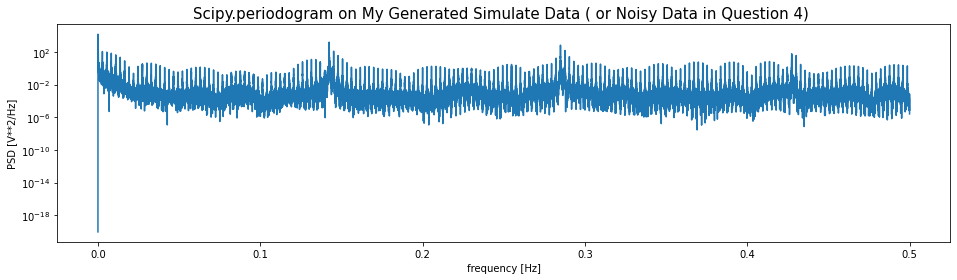

The Scipy.periodogram given period in Q.3.1 is : 52559.99999999999


In [61]:
# compare performance

'''For Noisy data 1'''
print('-------------------------------For Noisy data 1-----------------------------------------')
noisy_data1 = add_noise_one(simulate_data, 0.5)

# My ACF
noisy_period1, _ = autocorr_periodicity(noisy_data1)
print('The dominant period of original ACF in Q.2 is :', noisy_period1)

# My Periodogram
my_period1 , _ = my_periodogram(noisy_data1)
print('My own periodogram period in Q.3.2 is :', my_period1)

# My evaluation function
noisy_period1_new, _ = autocorr_periodicity_new(noisy_data1)
print('The new evaluation function finded period of  ACF in Q.3.3 is: ', noisy_period1_new)

# Scipy.signal.periodogram Algorithem
scipy_peirod1 = scipy_periodogram(noisy_data1)
print('The Scipy.periodogram given period in Q.3.1 is :', scipy_peirod1)


'''For Noisy data 2'''
print('-------------------------------For Noisy data 2------------------------------------------')
noisy_data2_2d = add_noise_two(simulate_data_2d, 0.5)
noisy_data2 = noisy_data2_2d.flatten()

# My ACF
noisy_period2, _ = autocorr_periodicity(noisy_data2)
print('The dominant period of original ACF in Q.2 is :', noisy_period2)

# My writen Periodogram Algorithem
my_peirod2, _ = my_periodogram(noisy_data2)
print('My own periodogram period in Q.3.2 is :', my_peirod2)

# My evaluation function
noisy_period2_new, _ = autocorr_periodicity_new(noisy_data2)
print('The new evaluation function finded period by ACF in Q.3.3 is: ', noisy_period2_new)

# Scipy.signal.periodogram Algorithem
scipy_peirod2 = scipy_periodogram(noisy_data2)
print('The Scipy.periodogram given period in Q.3.1 is :', scipy_peirod2)

### Conclusion
From the above experimentsresult we can see that :

1. Comparing above two Scipy.periodogram figures with Q 3.1 figure, we could ensure that the noise has already been added. 


2. For ACF function & own written periodogram :
    
    we could find that the performance of my ACF function and my own written periodogram algorithem are both perform stable, they give the same predicting result on both noisy added data. But stability does not mean that the algorithm I designed is good. There are three main reasons for this. One is that the noise I added is not enough to provide enough interference. On the other hand, the algorithm I designed is not sensitive enough to perceive interference. But in short, the two can finally output stable and the same results, which may also mean that my algorithm design has strong anti-interference ability and is reasonable and applicable.



3. However, for scipy.periodogram and my writen evaluation functions:
    
     there is a huge difference (untsbale) between the output results on noise data and normal data. I think the reason is that scipy provided algorithm is more intelligent and sensitive to detect noise. This is a good thing or it may be a bad thing, because Excessive sensitivity makes it difficult to perceive the regular pattern between in signal. But I’m not surprised by the bad results of the evaluation equation, because the evaluation function is designed according to a specific periodogram, so there will be a large gap.The evaluation function needs to be tailored to the problem.


(Write your report here)

## 5th part: Real life data

You will use data from the geolife datasets to test the time-series analysis methods that you developed. Your task is to apply the methods you just learned and interpret the data. 

[Download the data here](https://www.microsoft.com/en-us/download/details.aspx?id=52367). Select a participant and find out as much as you can about that participant. The participants differ a lot in terms of the number of collected trajectories, you can check several participants.

[The user guide of the entire dataset can be found here](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/User20Guide-1.2.pdf).

Use these questions as a guideline for your analysis: 
- Where was the data gathered? Can you find frequently visited locations by exploring the data?
- What is the general structure of the data? How much noise do you expect? What is the temporal granularity of your data? How long did your participant log their movement?
- Can you find periodic behaviors? What are the periodicities?
- If you cannot identify periodic behaviors: Can you explore why? What makes your data challenging? What realistic aspect of data is missing in your simulation? Having these challenges in mind what would be your topmost priorities, if you were to design a data collection protocol?



### Q 5.1

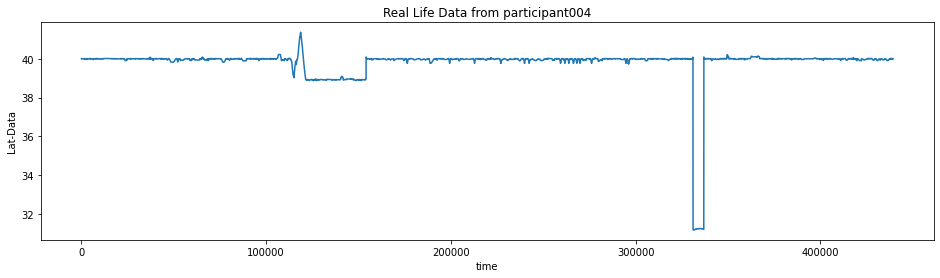

In [51]:
import numpy as np
import os
import itertools

filePath = "/workspaces/assignment-1-BraydenZhang/004/Trajectory"

real_lat_data=[]

for file in os.listdir(filePath):
    f = open(filePath + "/" + file,'r')
    
    data_list=f.readlines()    
    real_lat_data.append(data_list[6:])


data_1=[]
for i in range(len(real_lat_data)):
    list_data = real_lat_data[i]
    lat=[]
    for j in range(len(list_data )):
        every_row = list_data[j]
        first_column = every_row.split(',')[0:1]
        lat.append(float(first_column[0]))
        
    data_1.append(lat)
        
data= list(itertools.chain.from_iterable(data_1))

plt.figure(figsize=(16,4))
plt.plot(data);plt.title('Real Life Data from participant004')
plt.xlabel('time') ;plt.ylabel('Lat-Data')
plt.show()

### Q 5.2

In [52]:
# some general exploratory statistics to find out more about your participant
min_lat=min(data)
max_lat=max(data)
mode_num = sorted(data)[len(data)//2]
len(data)
type(data)

min_lat, max_lat, mode_num, len(data)

(31.167747, 41.367085, 39.992018, 439397)

### Q 5.3

In [ ]:
def autocorrelation_REAL(TSdata,tao):
    T = len(TSdata)
    average_value = np.mean(TSdata)
    TS1 = realTS[0:T-tao]
    TS2 = realTS[tao:]
    
    autocorr = 0
    
    for i in range(T-tao) :
        temp = ((TS1[i]-average_value)*(TS2[i]-average_value))/T
        autocorr = autocorr +temp
    
    return autocorr

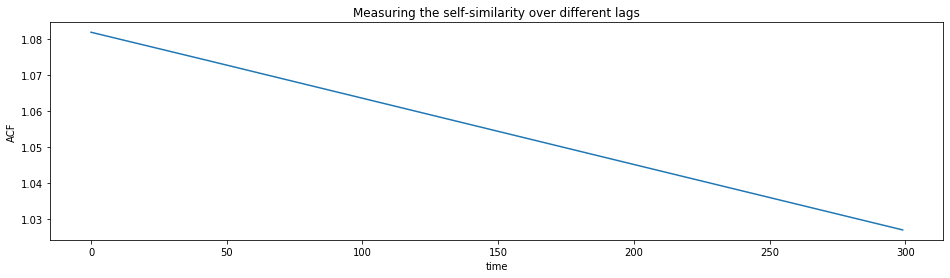

In [ ]:
#run (your own) ACF 
import matplotlib.pyplot as plt

realTS = np.zeros(shape=(len(data),1))
for i in range(len(data)) :
    realTS[i, 0] = data[i]


tao = 300

ACF = []

for i in range(tao):
    acf = autocorrelation_REAL(realTS,i)
    ACF.append(acf)

plt.figure(figsize=(16,4))
plt.plot(ACF);plt.title('Measuring the self-similarity over different lags')
plt.xlabel('time') ;plt.ylabel('ACF')
plt.show()

In [ ]:
autocorrelation(realTS,300)

array([1.02670401])

### Q 5.4

In [ ]:
#run periodogram on the data
PeriodogramPeriodicity(realTS)

219698.50000000003

### Conclusion
Little report:

Real-world data is often much larger than experimental data, so good hardware equipment is needed while optimizing the algorithm. Besides, during the experiment I find when we implement the real life data on our PC, multi-threaded calculation and the use of array instead of list can significantly increase the speed of other calculations.

For signal processing, there is no universal and effective periodogram method, and specific problems need to be analyzed in detail, and the periodogram is designed according to the characteristics of the signal itself.

For the periodogram provided by scipy, high sensitivity is a double-edged sword. On the one hand, it is easier to detect signal changes, but it also brings difficulties to the analysis of the signal-dominant period. A good periodogram method is resistant to noise and can identify real changes, so the use of machine learning methods can only eliminate noise interference, which may be a big trend in the future